In [0]:
from __future__ import print_function, division
from builtins import range, input

In [0]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
with open('/content/drive/My Drive/JSON_Files/user2movie.json', 'rb') as f:
  user2movie = pickle.load(f)

with open('/content/drive/My Drive/JSON_Files/movie2user.json', 'rb') as f:
  movie2user = pickle.load(f)

with open('/content/drive/My Drive/JSON_Files/usermovie2rating.json', 'rb') as f:
  usermovie2rating = pickle.load(f)

with open('/content/drive/My Drive/JSON_Files/usermovie2rating_test.json', 'rb') as f:
  usermovie2rating_test = pickle.load(f)

In [5]:
N = np.max(list(user2movie.keys())) + 1
# the test set may contain movies the train set doesn't have data on
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)

N: 1000 M: 200


In [0]:
# initialize variables
K = 10 # latent dimensionality
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(usermovie2rating.values()))

In [0]:
def get_loss(d):
  # d: (user_id, movie_id) -> rating
  N = float(len(d))
  sse = 0
  for k, r in d.items():
    i, j = k
    p = W[i].dot(U[j]) + b[i] + c[j] + mu
    sse += (p - r)*(p - r)
  return sse / N

epoch: 0
i: 0 N: 1000
i: 100 N: 1000
i: 200 N: 1000
i: 300 N: 1000
i: 400 N: 1000
i: 500 N: 1000
i: 600 N: 1000
i: 700 N: 1000
i: 800 N: 1000
i: 900 N: 1000
updated W and b: 0:00:02.786314
j: 0 M: 200
j: 20 M: 200
j: 40 M: 200
j: 60 M: 200
j: 80 M: 200
j: 100 M: 200
j: 120 M: 200
j: 140 M: 200
j: 160 M: 200
j: 180 M: 200
updated U and c: 0:00:02.961675
epoch duration: 0:00:05.749146
calculate cost: 0:00:00.391808
train loss: 0.694288587104055
test loss: 0.723844999748144
epoch: 1
i: 0 N: 1000
i: 100 N: 1000
i: 200 N: 1000
i: 300 N: 1000
i: 400 N: 1000
i: 500 N: 1000
i: 600 N: 1000
i: 700 N: 1000
i: 800 N: 1000
i: 900 N: 1000
updated W and b: 0:00:02.612376
j: 0 M: 200
j: 20 M: 200
j: 40 M: 200
j: 60 M: 200
j: 80 M: 200
j: 100 M: 200
j: 120 M: 200
j: 140 M: 200
j: 160 M: 200
j: 180 M: 200
updated U and c: 0:00:02.269387
epoch duration: 0:00:04.883900
calculate cost: 0:00:00.377145
train loss: 0.5480319078919503
test loss: 0.5934724071189789
epoch: 2
i: 0 N: 1000
i: 100 N: 1000
i: 200 N:

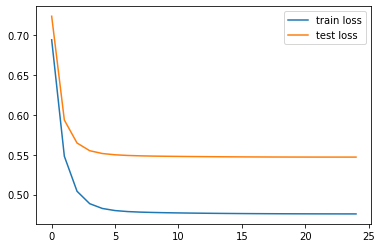

In [8]:
# train the parameters
epochs = 25
reg =20. # regularization penalty
train_losses = []
test_losses = []
for epoch in range(epochs):
  print("epoch:", epoch)
  epoch_start = datetime.now()
  # perform updates

  # update W and b
  t0 = datetime.now()
  for i in range(N):
    # for W
    matrix = np.eye(K) * reg
    vector = np.zeros(K)

    # for b
    bi = 0
    for j in user2movie[i]:
      r = usermovie2rating[(i,j)]
      matrix += np.outer(U[j], U[j])
      vector += (r - b[i] - c[j] - mu)*U[j]
      bi += (r - W[i].dot(U[j]) - c[j] - mu)

    # set the updates
    W[i] = np.linalg.solve(matrix, vector)
    b[i] = bi / (len(user2movie[i]) + reg)

    if i % (N//10) == 0:
      print("i:", i, "N:", N)
  print("updated W and b:", datetime.now() - t0)

  # update U and c
  t0 = datetime.now()
  for j in range(M):
    # for U
    matrix = np.eye(K) * reg
    vector = np.zeros(K)

    # for c
    cj = 0
    try:
      for i in movie2user[j]:
        r = usermovie2rating[(i,j)]
        matrix += np.outer(W[i], W[i])
        vector += (r - b[i] - c[j] - mu)*W[i]
        cj += (r - W[i].dot(U[j]) - b[i] - mu)

      # set the updates
      U[j] = np.linalg.solve(matrix, vector)
      c[j] = cj / (len(movie2user[j]) + reg)

      if j % (M//10) == 0:
        print("j:", j, "M:", M)
    except KeyError:
      # possible not to have any ratings for a movie
      pass
  print("updated U and c:", datetime.now() - t0)
  print("epoch duration:", datetime.now() - epoch_start)


  # store train loss
  t0 = datetime.now()
  train_losses.append(get_loss(usermovie2rating))

  # store test loss
  test_losses.append(get_loss(usermovie2rating_test))
  print("calculate cost:", datetime.now() - t0)
  print("train loss:", train_losses[-1])
  print("test loss:", test_losses[-1])


print("train losses:", train_losses)
print("test losses:", test_losses)

# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()